# Further analysis

We now take the ideas from the notes and attempt to understand them

In [96]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload

%autoreload 1

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from matplotlib.cm import get_cmap
import re
%aimport utils

# Make the backgrounds non-transparent
sns.set(style='darkgrid')
plt.rc('figure', facecolor='w')

sqlite_url = 'sqlite:///openra-20170606.db'

Let's start with the breakdown of versions of the game used. We see from the database that the `sysinfo` table contains the version of the game played. Let's download this data.

In [2]:
sysinfo = pd.read_sql(
        '''
        SELECT * FROM sysinfo
        WHERE updated IS NOT NULL
        GROUP BY system_id
        ''', sqlite_url)
sysinfo['updated'] = pd.to_datetime(sysinfo['updated'])
sysinfo['version'] = sysinfo['version'].astype(str)
sysinfo.head()

,system_id,updated,platform,os,runtime,gl,lang,version,mod,modversion,x64,windowsize,windowscale,sysinfoversion
0,None,2016-04-03 16:14:53,None,None,None,None,None,None,None,None,1,0x0,1,1
1,00011aff-e232-4033-852a-b2f026fa62a8,2016-10-08 03:46:50,Windows,Microsoft Windows NT 6.2.9200.0,.NET CLR 4.0.30319.42000,4.5.13417 Compatibility Profile Context 15.301...,en,release-20160508,ra,release-20160508,1,0x0,1,1
2,00012da9-b1d4-4b70-af89-562f53046e3e,2016-05-02 18:07:09,Linux,Unix 4.4.0.1,Mono 4.2.1 (Debian 4.2.1.102 dfsg2-6) CLR 4.0....,3.0 Mesa 11.1.2,de,playtest-20160424,ra,playtest-20160424,1,0x0,1,1
3,00015036-c5ff-45e4-9455-993ad99174fd,2017-02-23 15:47:02,Windows,Microsoft Windows NT 6.2.9200.0,.NET CLR 4.0.30319.18010,4.3.0,de,release-20161019,d2k,release-20161019,1,0x0,1,1
4,0001f37d-ff3a-4fcd-a6d9-e7763be9e242,2017-03-24 02:19:29,Windows,Microsoft Windows NT 6.2.9200.0,.NET CLR 4.0.30319.36366,4.3.12618 Compatibility Profile Context 13.251...,en,release-20161019,ra,release-20161019,1,0x0,1,1


In [3]:
game_versions = sysinfo['version'].dropna().astype(str)
print('Number of unique game versions: {}'.format(len(game_versions.unique())))

Number of unique game versions: 261


Now lots of these versions are a git hash. If we exclude git versions, how many unique versions are there?

In [4]:
git_version = game_versions.str.contains('git')
git_version.unique()

array([False,  True], dtype=bool)

In [5]:
non_git_versions = game_versions[~git_version]
print('Number of git versions: {}'.format(len(game_versions[git_version])))
print('Number of non-git versions: {}'.format(len(non_git_versions)))

non_git_versions.unique()

Number of git versions: 519
Number of non-git versions: 113208


array(['None', 'release-20160508', 'playtest-20160424', 'release-20161019',
       'release-20170421', 'release-20170527', 'release-20161015',
       'playtest-20160403', 'playtest-20170408', 'playtest-20160904',
       '{DEV_VERSION}', 'playtest-20170304', 'playtest-20161001', '9999',
       'Experimental v2.0', 'kang-b7cf0fe', 'AS20160909',
       'playtest-20170303', 'kang-d6397f0', 'bsfc-170318', 'kang-93b015c',
       '{SP_Build_20161016}', '{SP Build 20160820}', 'AS20170115',
       'cd-release-20170525', 'cd-release-20170603', 'kang-3513304',
       'Experimental v2.1', 'test2', 'playtest-20160403~69',
       'kang-92ecef6', 'kang-04a674c', '{GRAND DEVS version by Stas}',
       'AS20161120', 'kang-0cacd2b',
       'commit-fba590cdb3dd2efa548daed2b3d9424f5d3b5d87', 'kang-0a47c51',
       'kang-93b015c00', '20160513-dev', 'Experimental v2.2', '0.0.0.1',
       'kang-36a13c7', 'kang-3ec642b', 'version', 'kang-3eb0ab9',
       'Bleed-2017-02-16', 'Unknown', 'kang-fcba94c',
       '

I'm not too familiar with the versioning scheme of OpenRA but judging from the [news feed](http://www.openra.net/news/) the primary releases are either called `release-` or `playtest-`. We can therefore categorise the releases into three groups:

1. Official (named `release-` or `playtest-`)
2. Git
3. Other

It has already been shown that _most_ people are not running of the git branch (519/11372ver6).

In [6]:
def classify_version(version):
    if version is None:
        return 'unknown'
        
    version = str(version)    
    if 'git' in version:
        return 'git'
    elif ('release-' in version or 'playtest-' in version) and not version.startswith('cd'):
        return 'official'
    else:
        return 'unknown'


sysinfo['version_label'] = pd.Categorical(sysinfo['version'].apply(classify_version))


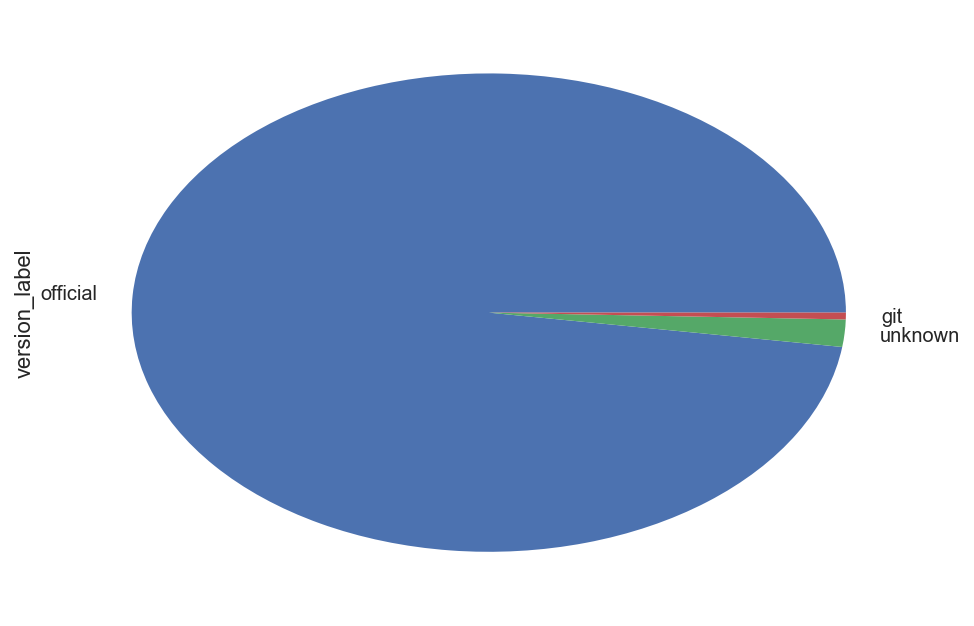

In [7]:
sysinfo['version_label'].value_counts().plot.pie()

We see that the _vast_ majority of people are running the official build. We can focus on the official build.

The official build has the date of release in the title. We start by parsing the release date into a python `date` object.

In [8]:
official_releases = sysinfo[sysinfo['version_label'] == 'official']

In [9]:
def parse_release_date(label):
    # note there is a ~69 in one of the entries. I assume this is some sort of patch release, so we ignore it for now
    date_part = label.split('-')[1].split('~')[0]
    year = int(date_part[:4])
    month = int(date_part[4:6])
    day = int(date_part[6:])
    return datetime.date(year, month, day)

official_releases['release_date'] = official_releases['version'].apply(parse_release_date)

/Users/simon/Documents/Development/openra-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
unique_releases = [val for val in official_releases['release_date'].unique() if val == val]
unique_releases

[datetime.date(2016, 5, 8),
 datetime.date(2016, 4, 24),
 datetime.date(2016, 10, 19),
 datetime.date(2017, 4, 21),
 datetime.date(2017, 5, 27),
 datetime.date(2016, 10, 15),
 datetime.date(2016, 4, 3),
 datetime.date(2017, 4, 8),
 datetime.date(2016, 9, 4),
 datetime.date(2017, 3, 4),
 datetime.date(2016, 10, 1),
 datetime.date(2017, 3, 3)]

12


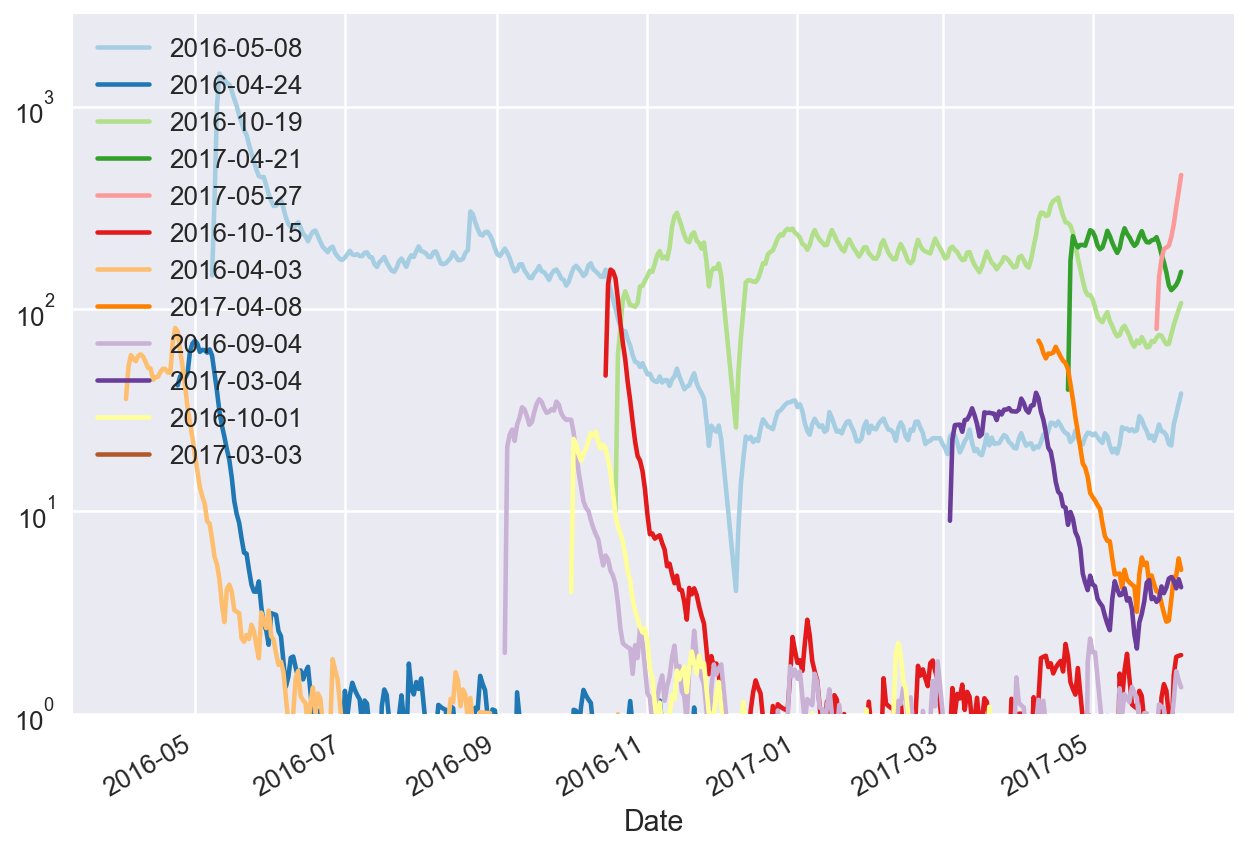

In [11]:
with sns.plotting_context('talk'):
    colour_map = get_cmap('Paired')
    fig, axis = plt.subplots()
    n_unique_releases = len(unique_releases)
    print(n_unique_releases)
    for i, release in enumerate(unique_releases):
        ind = official_releases['release_date'] == release
        subset = official_releases[ind]
        subset = subset.set_index(subset['updated'])
        
        # daily resampling
        resampled = subset.resample('D')['updated'].count()
        
        colour = i / n_unique_releases
        
        # Smoothing
        smoothed = resampled.ewm(com=3).mean()
        axis.semilogy(smoothed.index, smoothed.values, color=colour_map(colour), label=release)
        
    axis.legend(loc='best')
    axis.set(xlabel='Date', ylim=(1, None))
    fig.autofmt_xdate()

We find that new versions tend to have a quick uptake, however version `2016-10-19` has had quite a long life, wth a relatively stable install base. Version `2016-10-15` was quickly overtaken by it's more recent release. Going back to the release notes, there was two critical multiplayer bugs with that version.

It's quite nice to see that xmas is an obvious dip in the player base.

## Non-finished games

Can we break down the distribution of non-finished games?

In [25]:
game_stats = pd.read_sql(
    '''SELECT started.started, finished.finished, started.map, started.players
    FROM started
    LEFT JOIN finished using (game_id)''', sqlite_url)
game_stats.head()

,started,finished,map,players
0,2014-09-24 06:41:19,2014-09-24 07:14:51,3938bd242e16971eed2a9040f7af64d273bb91e1,1
1,2014-09-24 07:32:39,2014-09-24 07:43:47,02ad3dd33e4c78c26f041f74f71dfd0629824b4e,3
2,2014-09-24 07:53:55,2014-09-24 08:17:56,db3faf8e0c0bc9c53b3115c10eaef17249ccd50c,4
3,2014-09-24 08:01:57,2014-09-24 08:22:14,eddbb7b9938f5fda7975e2efa7a07cc7b445d014,4
4,2014-09-24 08:03:10,2014-09-24 08:31:08,32d21827fc3fb9f6b4e24fc395a7b626e5282496,2


In [26]:
unfinished = game_stats[game_stats.finished.apply(lambda f: f is None)]

,started,finished,map,players
45,2014-09-24 12:11:40,None,c02d977a4a358f982ff5d8adca27ebdd3f46f1e4,1
143,2014-09-24 12:56:00,None,11fd2f8a4a8b54d62ed076287c183c46fe9b2b44,2
161,2014-09-24 13:51:57,None,a1e88759117193b080452a4d27f7e205f476d0c9,8
203,2014-09-24 15:09:48,None,66a1e8714f13c0e02de73086055b829ff825089c,1
323,2014-09-24 20:36:09,None,bf528194f2483608ffafb4a5f26b43d21eb2c07b,3


In [28]:
n_unfinished = len(unfinished)
n_finished = len(game_stats) - n_unfinished
print('Number of unfinished games: {}'.format(n_unfinished))
print('Number of finished games: {}'.format(n_finished))
print('Fraction of unfinished games: {:.1f}%'.format(n_unfinished * 100 / (n_finished + n_unfinished)))

Number of unfinished games: 13931
Number of finished games: 429904
Fraction of unfinished games: 3.1%


## Effective screen size

We have the screen resolution of the submitted machines, as well as the window scaling. Before we break it down too much, let's see the distributions of these values.

In [29]:
screen_info = pd.read_sql(
    '''
    SELECT windowsize, windowscale
    FROM sysinfo
    GROUP BY system_id
    ''', sqlite_url)

In [38]:
counts = screen_info.windowsize.value_counts()
counts.head()

0x0          97748
1920x1080     6159
1366x768      2479
1600x900       796
1680x1050      732
Name: windowsize, dtype: int64

The vast majority of "resolutions" are `0x0` which is probably a collection error. Let's remove these.

In [40]:
screen_info = screen_info[screen_info.windowsize != '0x0']

In [42]:
counts = screen_info.windowsize.value_counts()
counts.head()

1920x1080    6159
1366x768     2479
1600x900      796
1680x1050     732
1536x864      711
Name: windowsize, dtype: int64

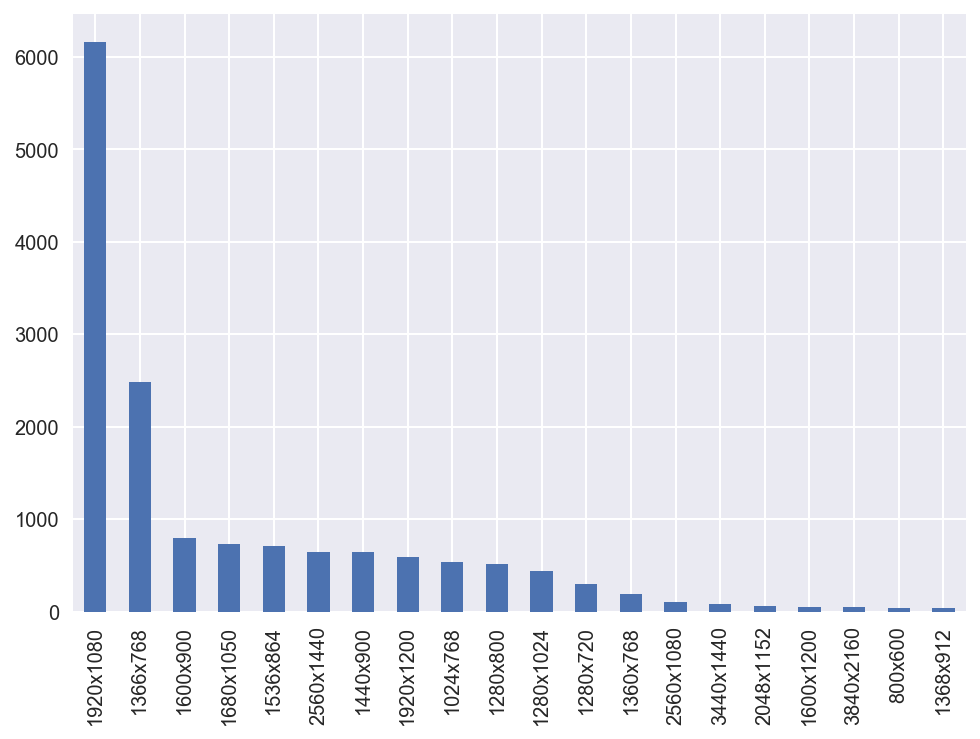

In [46]:
counts[:20].plot.bar()

By far the most common screen resolution is `1920x1080`. Interestingly the next most common resolution is `1366x768` which is common amongst lower spec laptops. What about the aspect ratios

In [60]:
def parse_aspect_ratio(resolution):
    try:
        width, height = tuple(map(int, resolution.split('x')))
        return width / height
    except (ValueError, ZeroDivisionError):
        return np.nan

screen_info['aspect_ratio'] = screen_info.windowsize.astype(str).apply(parse_aspect_ratio)

/Users/simon/Documents/Development/openra-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
print('Unique aspect ratios: {}'.format(np.sort(screen_info['aspect_ratio'].dropna().unique())))

Unique aspect ratios: [  0.           0.5          0.625        0.66666667   0.75         0.86363636
   0.88888889   0.95555556   1.           1.06666667   1.11764706
   1.13777778   1.14285714   1.171875     1.1796875    1.2          1.21428571
   1.23529412   1.24031008   1.25         1.25026969   1.25030525
   1.26446281   1.28         1.28205128   1.28571429   1.30081301
   1.30612245   1.3125       1.3132948    1.31740614   1.33203125   1.3325
   1.33333333   1.33371692   1.33387622   1.34736842   1.34765625
   1.35211268   1.35652174   1.36083744   1.3667426    1.3671875
   1.37142857   1.37579618   1.4          1.40625      1.40659341
   1.41666667   1.421875     1.42222222   1.42857143   1.4375       1.45833333
   1.46118721   1.46285714   1.46498278   1.48405797   1.49222798
   1.49938348   1.49939247   1.5          1.50037509   1.50058617
   1.50068399   1.50068587   1.50087566   1.50123457   1.50588235
   1.51245552   1.51315789   1.52777778   1.53         1.53008596
   1.53

There are some strange window resolutions here! What about window scaling factors? We find that the scaling factor sometimes has a comma in the place of the decimal place (possibly because of i18n).

In [82]:
def sanitise_scaling(scaling):
    try:
        scaling = str(scaling).replace(',', '.')
        return float(scaling)
    except ValueError:
        return np.nan

window_scalings = screen_info.windowscale.apply(sanitise_scaling).dropna()

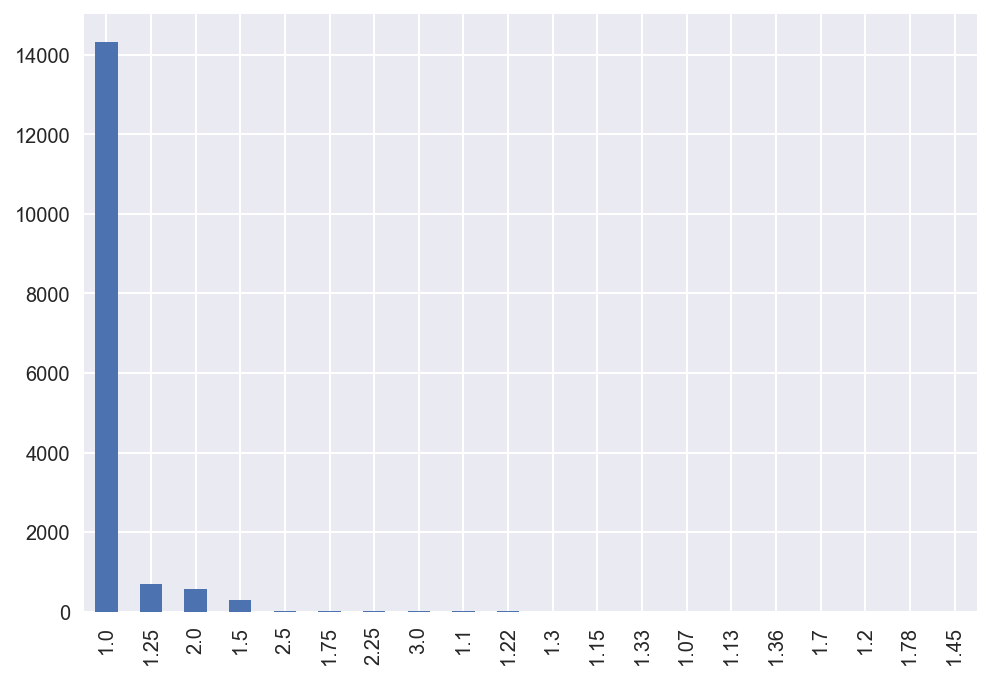

In [83]:
window_scalings.value_counts().plot.bar()

most of the scaling is 1.0. This is to be expected. We then have a smattering of smaller scaling factors.


## OpenGL versions

In [93]:
opengl_versions = pd.read_sql(
    '''
    SELECT gl FROM sysinfo
    WHERE gl IS NOT NULL
    GROUP BY system_id
    ''', sqlite_url)
opengl_versions.head()

,gl
0,4.5.13417 Compatibility Profile Context 15.301...
1,3.0 Mesa 11.1.2
2,4.3.0
3,4.3.12618 Compatibility Profile Context 13.251...
4,4.0.0 - Build 10.18.10.4491


In [94]:
print('Number of GL versions: {}'.format(len(opengl_versions['gl'].unique())))

Number of GL versions: 1875


In [95]:
opengl_versions['gl']

0         4.5.13417 Compatibility Profile Context 15.301...
1                                           3.0 Mesa 11.1.2
2                                                     4.3.0
3         4.3.12618 Compatibility Profile Context 13.251...
4                               4.0.0 - Build 10.18.10.4491
5                               4.0.0 - Build 10.18.10.4358
6                                           3.0 Mesa 11.2.1
7                   4.2.11672 Compatibility Profile Context
8                                                     3.3.0
9                                        2.1 INTEL-10.14.73
10                              4.0.0 - Build 10.18.10.4425
11                                       2.1 INTEL-10.24.45
12                                      4.5.0 NVIDIA 376.33
13                                      4.5.0 NVIDIA 382.05
14                               3.1.0 - Build 9.17.10.2932
15                                      4.5.0 NVIDIA 376.53
16        4.5.13431 Compatibility Profil

Looking at these values, there are a few common entries:

* Mesa
* NVIDIA
* INTEL
* Compatability Profile Context
* Build
* Plain version string

There is a lot of code to make sense of this, so I'll punt out to the local utils library.

In [175]:
parsed = list(utils.parse_gl_versions(opengl_versions['gl']))
driver = [p.driver for p in parsed]
opengl_version = [p.version for p in parsed]
driver_version = [p.driver_version for p in parsed]

In [176]:
opengl_versions['driver'] = driver
opengl_versions['version'] = opengl_version
opengl_versions['driver_version'] = driver_version

In [177]:
opengl_versions.driver.value_counts()

nvidia     38433
build      29871
compat     19580
mesa       12523
generic     7801
intel       5464
Name: driver, dtype: int64